# 모듈 불러오기

In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 시각화 함수

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [ ]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'

# 래

# 데이터 만들기에 필요한 값 선언

In [2]:
FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

PATH = 'data_in/ChatBotData.csv_short'
VOCAB_PATH = 'data_in/vocabulary.txt'

BATCH_SIZE = 64
MAX_SEQUENCE = 25

## 데이터 불러오기

In [3]:
def load_data(path):
    # 판다스를 통해서 데이터를 불러온다.
    data_df = pd.read_csv(path, header=0)
    # 질문과 답변 열을 가져와 question과 answer에 넣는다.
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer

In [4]:
inputs, outputs = load_data(PATH)

## 토크나이징과 어휘사전 생성

In [5]:
def data_tokenizer(data):
    # 토크나이징 해서 담을 배열 생성
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])"
        # 위 필터와 같은 값들을 정규화 표현식을
        # 통해서 모두 "" 으로 변환 해주는 부분이다.
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)
    # 토그나이징과 정규표현식을 통해 만들어진
    # 값들을 넘겨 준다.
    return [word for word in words if word]

def load_vocabulary(path, vocab_path):
    # 사전을 담을 배열 준비한다.
    vocabulary_list = []
    # 사전을 구성한 후 파일로 저장 진행한다.
    # 그 파일의 존재 유무를 확인한다.
    if not os.path.exists(vocab_path):
        # 이미 생성된 사전 파일이 존재하지 않으므로
        # 데이터를 가지고 만들어야 한다.
        # 그래서 데이터가 존재 하면 사전을 만들기 위해서
        # 데이터 파일의 존재 유무를 확인한다.
        if (os.path.exists(path)):
            # 데이터가 존재하니 판단스를 통해서
            # 데이터를 불러오자
            data_df = pd.read_csv(path, encoding='utf-8')
            # 판다스의 데이터 프레임을 통해서
            # 질문과 답에 대한 열을 가져 온다.
            question, answer = list(data_df['Q']), list(data_df['A'])
#             if DEFINES.tokenize_as_morph:  # 형태소에 따른 토크나이져 처리
#                 question = prepro_like_morphlized(question)
#                 answer = prepro_like_morphlized(answer)
            data = []
            # 질문과 답변을 extend을
            # 통해서 구조가 없는 배열로 만든다.
            data.extend(question)
            data.extend(answer)
            # 토큰나이져 처리 하는 부분이다.
            words = data_tokenizer(data)
            # 공통적인 단어에 대해서는 모두
            # 필요 없으므로 한개로 만들어 주기 위해서
            # set해주고 이것들을 리스트로 만들어 준다.
            words = list(set(words))
            # 데이터 없는 내용중에 MARKER를 사전에
            # 추가 하기 위해서 아래와 같이 처리 한다.
            # 아래는 MARKER 값이며 리스트의 첫번째 부터
            # 순서대로 넣기 위해서 인덱스 0에 추가한다.
            # PAD = "<PADDING>"
            # STD = "<START>"
            # END = "<END>"
            # UNK = "<UNKNWON>"
            words[:0] = MARKER
        # 사전을 리스트로 만들었으니 이 내용을
        # 사전 파일을 만들어 넣는다.
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    # 사전 파일이 존재하면 여기에서
    # 그 파일을 불러서 배열에 넣어 준다.
    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    # 배열에 내용을 키와 값이 있는
    # 딕셔너리 구조로 만든다.
    char2idx, idx2char = make_vocabulary(vocabulary_list)
    # 두가지 형태의 키와 값이 있는 형태를 리턴한다.
    # (예) 단어: 인덱스 , 인덱스: 단어)
    return char2idx, idx2char, len(char2idx)


def make_vocabulary(vocabulary_list):
    # 리스트를 키가 단어이고 값이 인덱스인
    # 딕셔너리를 만든다.
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}
    # 리스트를 키가 인덱스이고 값이 단어인
    # 딕셔너리를 만든다.
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}
    # 두개의 딕셔너리를 넘겨 준다.
    return char2idx, idx2char

In [6]:
char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH)

## 학습 데이터 생성

In [7]:
def enc_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의
    # 길이를 가지고 있다.(누적된다.)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)

    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 인코딩 할때
        # 가지고 있기 위한 배열이다.
        sequence_index = []
        # 문장을 스페이스 단위로
        # 자르고 있다.
        for word in sequence.split():
            # 잘려진 단어들이 딕셔너리에 존재 하는지 보고
            # 그 값을 가져와 sequence_index에 추가한다.
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            # 잘려진 단어가 딕셔너리에 존재 하지 않는
            # 경우 이므로 UNK(2)를 넣어 준다.
            else:
                sequence_index.extend([dictionary[UNK]])
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과
    # 그 길이를 넘겨준다.
    return np.asarray(sequences_input_index), sequences_length

In [8]:
def dec_output_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_output_index = []
    # 하나의 디코딩 입력 되는 문장의
    # 길이를 가지고 있다.(누적된다)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 디코딩 할때 가지고
        # 있기 위한 배열이다.
        sequence_index = []
        # 디코딩 입력의 처음에는 START가 와야 하므로
        # 그 값을 넣어 주고 시작한다.
        # 문장에서 스페이스 단위별로 단어를 가져와서 딕셔너리의
        # 값인 인덱스를 넣어 준다.
        sequence_index = [dictionary[STD]] + [dictionary[word] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_output_index 넣어 준다.
        sequences_output_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_output_index), sequences_length

In [9]:
def dec_target_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_target_index = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 문장에서 스페이스 단위별로 단어를 가져와서
        # 딕셔너리의 값인 인덱스를 넣어 준다.
        # 디코딩 출력의 마지막에 END를 넣어 준다.
        sequence_index = [dictionary[word] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        # 그리고 END 토큰을 넣어 준다
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_target_index에 넣어 준다.
        sequences_target_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_target_index)

In [10]:
index_inputs, input_seq_len = enc_processing(inputs, char2idx)
index_outputs, output_seq_len = dec_output_processing(outputs, char2idx)
index_targets = dec_target_processing(outputs, char2idx)

## 데이터 마스크 생성

In [12]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [13]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [14]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [15]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

## Model 생성

In [16]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [17]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


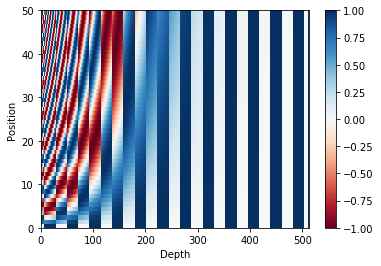

In [18]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [21]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])


In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [23]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__()
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

### 모델 실행 테스트

In [27]:
kargs = {'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': END_INDEX,
         'rate': 0.1
        }

model = Transformer(**kargs)

## 모델 학습 준비

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss_function,
              metrics=[accuracy_function])

In [30]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=True)

history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=4, epochs=20,
                    validation_split=0.1, callbacks=[earlystop_callback, cp_callback])

Train on 18 samples, validate on 2 samples
Epoch 1/20
18/18 [==============================] - 11s 591ms/sample - loss: 0.9334 - accuracy_function: 0.8428 - val_loss: 0.6233 - val_accuracy_function: 0.8460
Epoch 2/20
18/18 [==============================] - 1s 42ms/sample - loss: 0.6539 - accuracy_function: 0.8512 - val_loss: 0.5680 - val_accuracy_function: 0.8520
Epoch 3/20
18/18 [==============================] - 1s 43ms/sample - loss: 0.5430 - accuracy_function: 0.8546 - val_loss: 0.6156 - val_accuracy_function: 0.8573
Epoch 4/20
18/18 [==============================] - 1s 43ms/sample - loss: 0.4426 - accuracy_function: 0.8620 - val_loss: 0.5118 - val_accuracy_function: 0.8635
Epoch 5/20
18/18 [==============================] - 1s 44ms/sample - loss: 0.3389 - accuracy_function: 0.8690 - val_loss: 0.5437 - val_accuracy_function: 0.8716
Epoch 6/20
18/18 [==============================] - 1s 41ms/sample - loss: 0.2290 - accuracy_function: 0.8772 - val_loss: 0.4300 - val_accuracy_functi

### 출력값 보이기

In [31]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)
print(' '.join([idx2char[o] for o in outputs]))

In [34]:
outputs = model.inference(test_index_inputs)
' '.join([idx2char[o] for o in outputs])

'평소에 필요했던 게 좋을 것 같아요'